In [1]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_dual_results(path):
    buffer_dist = []
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    max_size0 = 0
    max_size1 = 0
    for i in range(20):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]

    for i in range(20,40):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size1):
            max_size1 = th[0]

    print("CCEH0 max runtime = ",max_size0, "CCEH1 max runtime = ", max_size1)
    
    MAX_SIZE = min(max_size0, max_size1)

    cceh0 = np.zeros(max_size0)
    cceh1 = np.zeros(max_size1)
    
    for i in range(20):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    cceh0_Mops = cceh0[:MAX_SIZE]/1024/1024
    time_x = np.array([i for i in np.arange(0.5, (MAX_SIZE + 1)/2, 0.5)])
    through_x = cceh0_Mops
    print("Through0: ", sum(through_x), "/", time_x[-1], sum(through_x)/time_x[-1])

    for i in range(20, 40):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]

        padding = np.pad(eopch, (0,max_size1-cur_length), 'constant', constant_values=(0,0))
        cceh1 += padding
    cceh1_Mops = cceh1[:MAX_SIZE]/1014/1024
    time_y = np.array([i for i in np.arange(0.5, (MAX_SIZE + 1)/2, 0.5)])
    through_y = cceh1_Mops
    print("Through1: ", sum(through_y), "/", time_y[-1], sum(through_y)/time_y[-1])
    
    print("Overall throughput = ", (sum(through_x) + sum(through_y))/ (MAX_SIZE/2) )
    return time_x, through_x, time_y, through_y

In [2]:
# time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_multi/cceh2_dynamic_g1.txt")
time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_bufferdist/ccehdual2_g5.txt")
time_f0, through_f0, time_f1, through_f1 = get_dual_results("./results_multi/cceh2_fixed_g5.txt")

print (len(time_d0), len(through_d0), len(time_d1), len(through_d1))



CCEH0 max runtime =  27 CCEH1 max runtime =  13
Through0:  37.63866424560547 / 6.5 5.790563730093149
Through1:  110.74642504930966 / 6.5 17.037911546047642
Overall throughput =  22.82847527614079
CCEH0 max runtime =  30 CCEH1 max runtime =  18
Through0:  47.12200164794922 / 9.0 5.235777960883246
Through1:  113.17820050542406 / 9.0 12.575355611713784
Overall throughput =  17.81113357259703
13 13 13 13


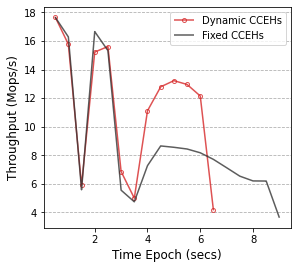

In [3]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['Dynamic-CCEH0', 'Dynamic-CCEH1', 'Dynamic CCEHs', 'Fixed-CCEH0', 'Fixed-CCEH1', 'Fixed CCEHs']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True, sharex=True, sharey=True)


if (through_d0.shape[0] > through_d1.shape[0]):
    thr1 = np.pad(through_d1, (0,through_d0.shape[0] - through_d1.shape[0]), 'constant', constant_values=(0,0))
    ax.plot(time_d0, thr1+through_d0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)
else:
    thr0 = np.pad(through_d0, (0,through_d1.shape[0] - through_d0.shape[0]), 'constant', constant_values=(0,0))
    ax.plot(time_d1, thr0+through_d1, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)

if (through_f0.shape[0] > through_f1.shape[0]):
    thrb = np.pad(through_f1, (0,through_f0.shape[0] - through_f1.shape[0]), 'constant', constant_values=(0,0))
    ax.plot(time_f0, thrb+through_f0, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)
else:
    thra = np.pad(through_f0, (0,through_f1.shape[0] - through_f0.shape[0]), 'constant', constant_values=(0,0))
    ax.plot(time_f1, thra+through_f1, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper right")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax[0,1].set_title('Time Epoch(1 secs) Throughput \n CCEH0 70% Write CCEH1 100% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (secs)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

fig.savefig("results_multi/cmp_g5_onlywritesfactor.pdf", bbox_inches='tight', pad_inches=0)

# Variable Buffer Size

In [31]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_dual_results(path):
    buffer_dist = []
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    max_size0 = 0
    max_size1 = 0
    for i in range(16):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]
    
    MAX_SIZE = max_size0

    cceh0 = np.zeros(max_size0)
    
    for i in range(16):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    print(cceh0, cceh0/0.1/1024/1024, sum(cceh0))
    cceh0_Mops = cceh0[:MAX_SIZE]/0.5/1024/1024
    time_x = np.array([i for i in np.arange(0.5, (MAX_SIZE + 1)/2, 0.5)])
    through_x = cceh0_Mops
    print("Through0: ", sum(through_x), "/", time_x[-1], sum(through_x)/time_x[-1])

    return time_x, through_x

In [35]:
time_d0, through_d0 = get_dual_results("./variable_buffersize/BufferedCCEH_8K.txt")
time_d1, through_d1 = get_dual_results("./variable_buffersize/BufferedCCEH_avg_8K.txt")
time_d2, through_d2 = get_dual_results("./variable_buffersize/BufferedCCEH_avg2814_8K.txt")



[5659000. 1694000. 4375000.  808000. 4186000. 1815000. 3418000. 2003000.
 1383000. 3141000. 1463000. 1168000. 2700000. 2273000. 2138000. 3361000.
 3186000. 2306000. 1628000. 1676000. 1749000. 1188000.  991000.  983000.
 1295000. 1751000. 1623000. 1571000. 2013000. 2856000. 2822000. 2247000.
 2075000. 2280000. 2605000. 2770000. 2928000. 2713000. 2712000. 2419000.
 2016000. 1683000. 1426000. 1229000. 1097000.  986000.  911000.  894000.
  868000.  871000.  856000.  891000.  971000. 1039000. 1132000. 1240000.
 1384000. 1671000. 1921000. 1990000. 1854000.  122000.] [53.96842957 16.15524292 41.72325134  7.70568848 39.92080688 17.30918884
 32.59658813 19.10209656 13.1893158  29.95491028 13.95225525 11.13891602
 25.74920654 21.67701721 20.38955688 32.05299377 30.38406372 21.99172974
 15.52581787 15.98358154 16.67976379 11.32965088  9.45091248  9.37461853
 12.3500824  16.69883728 15.47813416 14.98222351 19.19746399 27.23693848
 26.91268921 21.42906189 19.78874207 21.74377441 24.84321594 26.4167

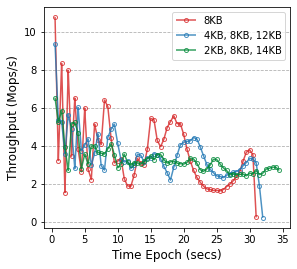

In [45]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', '#008837']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['8KB', '4KB, 8KB, 12KB', '2KB, 8KB, 14KB']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True, sharex=True, sharey=True)


ax.plot(time_d0, through_d0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[0], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_d1, through_d1, color=colors[2], marker=markers[2], dashes=dashes[2], label = label[1], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_d2, through_d2, color=colors[6], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)


ax.legend(loc="upper right")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax[0,1].set_title('Time Epoch(1 secs) Throughput \n CCEH0 70% Write CCEH1 100% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (secs)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

fig.savefig("./variable_buffersize/test.pdf", bbox_inches='tight', pad_inches=0)